# testing pipeline 3

The purpose of this is to test how to incorporate the deep learning models with my class

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from utils import *
from sklearn.metrics import mean_squared_error

In [5]:
#first dataloader test
dataloader = LoadData(impute='KNN',load = True)
cv = CV(dataloader)
print(cv.predict.shape)
#seems to work just fine, let's also test load not true

KeyboardInterrupt: 

In [ ]:
# dataloader = LoadData(impute='mean',load = False)
# cv = CV(dataloader)
# it works

In [ ]:
#now let's see how the PL model works
torch.set_float32_matmul_precision('medium')
os.environ["CUDA_LAUNCH_BLOCKING"] = "0"

class Net(pl.LightningModule):
    def __init__(self, cv=None): #if we implement the model there, can directly use cv.predict shape
        super(Net, self).__init__()
        self.fc1 = nn.Linear(251, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 1039)
        self.losses = []

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # No activation on final layer as it's a regression task
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)
        self.losses.append(loss)
        return {'test_loss': loss}, y_hat

    def on_test_end(self):
        avg_loss = torch.stack([x for x in self.losses]).mean()
        print(f'avg_test_loss: {avg_loss}')
        #self.log('avg_test_loss', avg_loss)
        
    def predict_step(self, batch, batch_idx):
        x, _ = batch
        outputs = self(x)
        return outputs



#trainer = pl.Trainer(max_epochs=10, accelerator='gpu', devices=1)  # Set the number of epochs and gpus
#print(torch.cuda.memory_allocated(device))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)

# trainer.fit(model, train_loader, test_loader)  # Train the model

for i in range(len(cv.fold_list)):
    #get the indices
    test_idx = cv.fold_list[i]
    #get the data
    m_train = np.delete(cv.met, test_idx, axis = 0) #axis 0 deletes the rows with the test_idx as we hope
    m_test = cv.met[test_idx,:]
    p_train = np.delete(cv.prot, test_idx, axis = 0)
    p_test = cv.prot[test_idx,:]
    X_train = torch.tensor(m_train, dtype=torch.float32).to(device)
    y_train = torch.tensor(p_train, dtype=torch.float32).to(device)
    X_test = torch.tensor(m_test, dtype=torch.float32).to(device)
    y_test = torch.tensor(p_test, dtype=torch.float32).to(device)
    
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0) #numworkers is 0 for now, because we at high ram usage
    #predict the data
    trainer = pl.Trainer(max_epochs=10, accelerator='gpu', devices=1)
    
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    
    trainer.fit(model, train_loader, test_loader)
    
    pred = trainer.predict(model, test_loader)
    pred = torch.cat(pred, dim=0).cpu().numpy()
    #save out the data
    cv.save_out(pred, i)

/home/sat4017/miniforge3/envs/prot_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/sat4017/miniforge3/envs/prot_torch/lib/python3 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name | Type   | Params
--------------------------------
0 | fc1  | Linear | 129 K 
1 | fc2  | Linear | 262 K 
2 | fc3  | Linear | 533 K 
--------------------------------
924 K     Trainable params
0         Non-trainable params
924 K     Total params
3.699     Total estimated model params size (MB)


/home/sat4017/miniforge3/envs/prot_torch/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=111` in the `DataLoader` to improve performance.
/home/sat4017/miniforge3/envs/prot_torch/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=111` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 267.75it/s, v_num=38]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 254.87it/s, v_num=38]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]
/home/sat4017/miniforge3/envs/prot_torch/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=111` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 41/41 [00:00<00:00, 707.92it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name | Type   | Params
--------------------------------
0 | fc1  | Linear | 129 K 
1 | fc2  | Linear | 262 K 
2 | fc3  | Linear | 533 K 
--------------------------------
924 K     Trainable params
0         Non-trainable params
924 K     Total params
3.699     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 291.36it/s, v_num=39]       

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 277.00it/s, v_num=39]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting DataLoader 0: 100%|██████████| 41/41 [00:00<00:00, 764.97it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name | Type   | Params
--------------------------------
0 | fc1  | Linear | 129 K 
1 | fc2  | Linear | 262 K 
2 | fc3  | Linear | 533 K 
--------------------------------
924 K     Trainable params
0         Non-trainable params
924 K     Total params
3.699     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 291.13it/s, v_num=40]       

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 275.79it/s, v_num=40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting DataLoader 0: 100%|██████████| 41/41 [00:00<00:00, 768.81it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name | Type   | Params
--------------------------------
0 | fc1  | Linear | 129 K 
1 | fc2  | Linear | 262 K 
2 | fc3  | Linear | 533 K 
--------------------------------
924 K     Trainable params
0         Non-trainable params
924 K     Total params
3.699     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 290.41it/s, v_num=41]       

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 275.33it/s, v_num=41]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting DataLoader 0: 100%|██████████| 41/41 [00:00<00:00, 760.02it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name | Type   | Params
--------------------------------
0 | fc1  | Linear | 129 K 
1 | fc2  | Linear | 262 K 
2 | fc3  | Linear | 533 K 
--------------------------------
924 K     Trainable params
0         Non-trainable params
924 K     Total params
3.699     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 291.82it/s, v_num=42]       

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 277.50it/s, v_num=42]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting DataLoader 0: 100%|██████████| 41/41 [00:00<00:00, 761.77it/s]


In [ ]:
#find any rows or columns of cv.predict that are 0

for row in range(cv.predict.shape[0]):
    if np.sum(cv.predict[row,:]) == 0:
        print(row)

for col in range(cv.predict.shape[1]):
    if np.sum(cv.predict[:,col]) == 0:
        print(col)

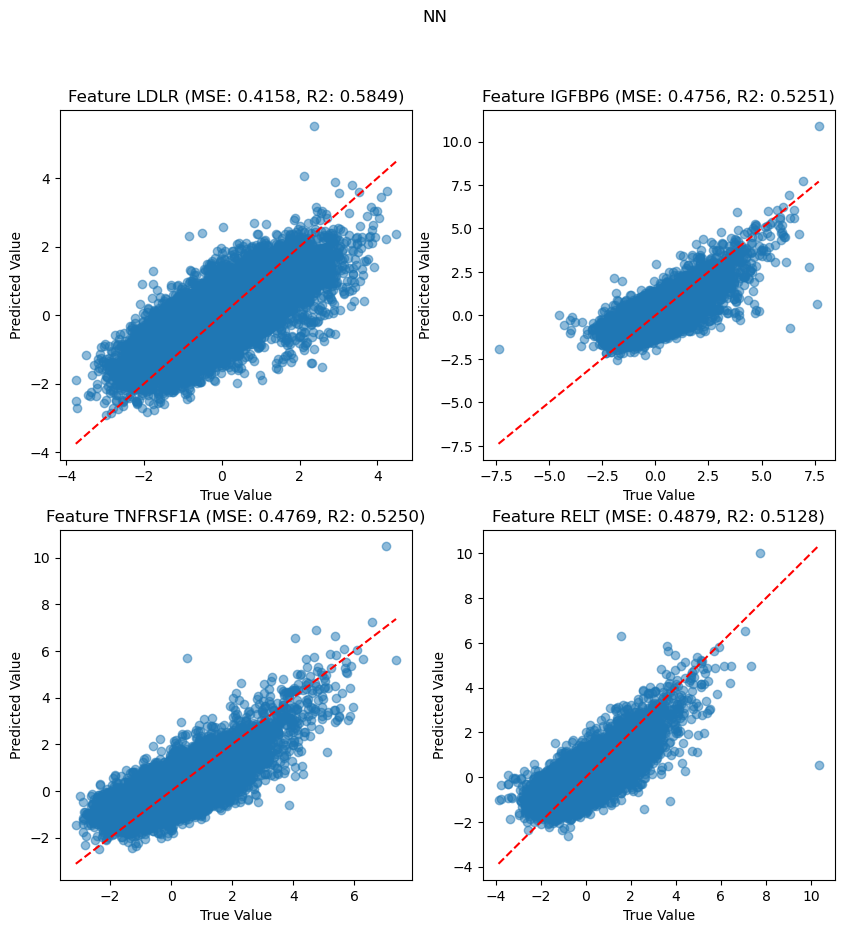

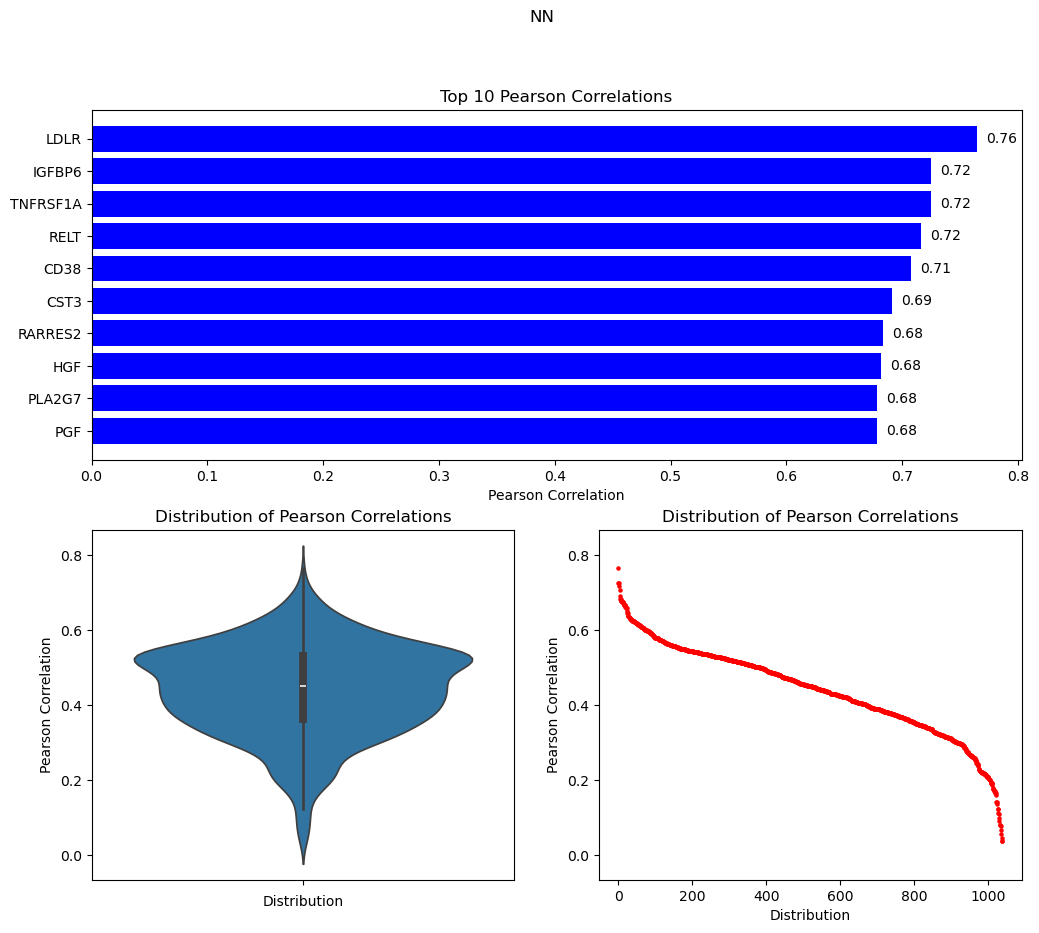

In [ ]:
#now we look at the plots
fig,axs = cv.idx_plot(feature_list = np.argsort(mean_squared_error(cv.prot, cv.predict, multioutput='raw_values'))[:4])
fig.suptitle('NN')
plt.show(fig)

fig,axs = cv.pred_summary_plot()
fig.suptitle('NN')
plt.show(fig)

In [ ]:
#now let's incorporate the model into the pipeline for CV

#let's make it modular first

class Net(pl.LightningModule):
    def __init__(self, input_dim=251, output_dim=1039, hidden_dims=[512, 512], custom_layers=None):
        super(Net, self).__init__()
        
        # Use custom layers if provided
        if custom_layers:
            self.layers = custom_layers
        else:
            all_layers = []
            last_dim = input_dim
            for hidden_dim in hidden_dims:
                all_layers.extend([nn.Linear(last_dim, hidden_dim), nn.ReLU()])
                last_dim = hidden_dim
            all_layers.append(nn.Linear(last_dim, output_dim))
            self.layers = nn.Sequential(*all_layers)
        
        self.losses = []

    def forward(self, x):
        x = self.layers(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)
        self.losses.append(loss)
        return {'test_loss': loss}, y_hat

    def on_test_end(self):
        avg_loss = torch.stack([x for x in self.losses]).mean()
        print(f'avg_test_loss: {avg_loss}')
        #self.log('avg_test_loss', avg_loss)
        
    def predict_step(self, batch, batch_idx):
        x, _ = batch
        outputs = self(x)
        return outputs
    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)

# trainer.fit(model, train_loader, test_loader)  # Train the model

for i in range(len(cv.fold_list)):
    #get the indices
    test_idx = cv.fold_list[i]
    #get the data
    m_train = np.delete(cv.met, test_idx, axis = 0) #axis 0 deletes the rows with the test_idx as we hope
    m_test = cv.met[test_idx,:]
    p_train = np.delete(cv.prot, test_idx, axis = 0)
    p_test = cv.prot[test_idx,:]
    X_train = torch.tensor(m_train, dtype=torch.float32).to(device)
    y_train = torch.tensor(p_train, dtype=torch.float32).to(device)
    X_test = torch.tensor(m_test, dtype=torch.float32).to(device)
    y_test = torch.tensor(p_test, dtype=torch.float32).to(device)
    
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0) #numworkers is 0 for now, because we at high ram usage
    #predict the data
    trainer = pl.Trainer(max_epochs=10, accelerator='gpu', devices=1)
    
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    
    trainer.fit(model, train_loader, test_loader)
    
    pred = trainer.predict(model, test_loader)
    pred = torch.cat(pred, dim=0).cpu().numpy()
    #save out the data
    cv.save_out(pred, i)

/home/sat4017/miniforge3/envs/prot_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/sat4017/miniforge3/envs/prot_torch/lib/python3 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 924 K 
--------------------------------------
924 K     Trainable params
0         Non-trainable params
924 K     Total params
3.699     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/sat4017/miniforge3/envs/prot_torch/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=111` in the `DataLoader` to improve performance.


/home/sat4017/miniforge3/envs/prot_torch/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=111` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 294.26it/s, v_num=43]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 279.04it/s, v_num=43]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]
/home/sat4017/miniforge3/envs/prot_torch/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=111` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 41/41 [00:00<00:00, 770.29it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 924 K 
--------------------------------------
924 K     Trainable params
0         Non-trainable params
924 K     Total params
3.699     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 291.62it/s, v_num=44]       

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 275.71it/s, v_num=44]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting DataLoader 0: 100%|██████████| 41/41 [00:00<00:00, 707.30it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 924 K 
--------------------------------------
924 K     Trainable params
0         Non-trainable params
924 K     Total params
3.699     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 294.25it/s, v_num=45]       

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 279.53it/s, v_num=45]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting DataLoader 0: 100%|██████████| 41/41 [00:00<00:00, 753.76it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 924 K 
--------------------------------------
924 K     Trainable params
0         Non-trainable params
924 K     Total params
3.699     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 297.19it/s, v_num=46]       

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 282.27it/s, v_num=46]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting DataLoader 0: 100%|██████████| 41/41 [00:00<00:00, 757.68it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 924 K 
--------------------------------------
924 K     Trainable params
0         Non-trainable params
924 K     Total params
3.699     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 294.54it/s, v_num=47]       

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 262.79it/s, v_num=47]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting DataLoader 0: 100%|██████████| 41/41 [00:00<00:00, 737.65it/s]


# testing it in CV class with default and adding hidden dims

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from utils import *
from sklearn.metrics import mean_squared_error
#first dataloader test
dataloader = LoadData(impute='KNN',load = True)
cv = CV(dataloader)
print(cv.predict.shape)
#seems to work just fine, let's also test load not true

(25818, 1039)


In [2]:
cv.train_loop_pl()

Training Folds:   0%|          | 0/5 [00:00<?, ?it/s]

/home/sat4017/miniforge3/envs/prot_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/sat4017/miniforge3/envs/prot_torch/lib/python3 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/sat4017/miniforge3/envs/prot_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/sat4017/miniforge3/envs/prot_to

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/sat4017/miniforge3/envs/prot_torch/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=111` in the `DataLoader` to improve performance.


/home/sat4017/miniforge3/envs/prot_torch/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=111` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 314.01it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 297.92it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]
/home/sat4017/miniforge3/envs/prot_torch/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=111` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 41/41 [00:00<00:00, 738.34it/s]


Training Folds:  20%|██        | 1/5 [00:07<00:28,  7.03s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/sat4017/miniforge3/envs/prot_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:630: Checkpoint directory /home/sat4017/PRIME/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 924 K 
--------------------------------------
924 K     Trainable params
0         Non-trainable params
924 K     Total params
3.699     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 294.02it/s]                 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 278.93it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting DataLoader 0: 100%|██████████| 41/41 [00:00<00:00, 756.14it/s]


Training Folds:  40%|████      | 2/5 [00:12<00:19,  6.34s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 924 K 
--------------------------------------
924 K     Trainable params
0         Non-trainable params
924 K     Total params
3.699     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 310.99it/s]                 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 294.14it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting DataLoader 0: 100%|██████████| 41/41 [00:00<00:00, 733.89it/s]


Training Folds:  60%|██████    | 3/5 [00:18<00:12,  6.08s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 924 K 
--------------------------------------
924 K     Trainable params
0         Non-trainable params
924 K     Total params
3.699     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 310.69it/s]                 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 293.79it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting DataLoader 0: 100%|██████████| 41/41 [00:00<00:00, 739.83it/s]


Training Folds:  80%|████████  | 4/5 [00:24<00:05,  5.96s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 924 K 
--------------------------------------
924 K     Trainable params
0         Non-trainable params
924 K     Total params
3.699     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 317.31it/s]                 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 300.27it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting DataLoader 0: 100%|██████████| 41/41 [00:00<00:00, 746.89it/s]


Training Folds: 100%|██████████| 5/5 [00:30<00:00,  6.02s/it]


In [3]:
#now do it with our custom layers stuff

custom_layers = nn.Sequential(
    nn.Linear(251, 256),
    nn.ReLU(),
    nn.Linear(256, 512),
    nn.ReLU(),
    nn.Linear(512, 1024),
    nn.ReLU(),
    nn.Linear(1024, 1039)
)

cv.train_loop_pl(custom_layers=custom_layers)

Training Folds:   0%|          | 0/5 [00:00<?, ?it/s]/home/sat4017/miniforge3/envs/prot_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/sat4017/miniforge3/envs/prot_torch/lib/python3 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/sat4017/miniforge3/envs/prot_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:630: Checkpoint directory /home/sat4017/PRIME/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name   | Type       | Params
----

/home/sat4017/miniforge3/envs/prot_torch/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=111` in the `DataLoader` to improve performance.
/home/sat4017/miniforge3/envs/prot_torch/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=111` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 296.67it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 266.32it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]
/home/sat4017/miniforge3/envs/prot_torch/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=111` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 41/41 [00:00<00:00, 816.92it/s]


Training Folds:  20%|██        | 1/5 [00:06<00:24,  6.23s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 1.8 M 
--------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.146     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 298.45it/s]                 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 264.41it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting DataLoader 0: 100%|██████████| 41/41 [00:00<00:00, 820.74it/s]


Training Folds:  40%|████      | 2/5 [00:12<00:18,  6.22s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 1.8 M 
--------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.146     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 295.30it/s]                 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 270.71it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting DataLoader 0: 100%|██████████| 41/41 [00:00<00:00, 820.90it/s]


Training Folds:  60%|██████    | 3/5 [00:18<00:12,  6.21s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 1.8 M 
--------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.146     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 297.36it/s]                 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 273.24it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting DataLoader 0: 100%|██████████| 41/41 [00:00<00:00, 813.84it/s]


Training Folds:  80%|████████  | 4/5 [00:24<00:06,  6.25s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 1.8 M 
--------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.146     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 296.49it/s]                 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 271.16it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting DataLoader 0: 100%|██████████| 41/41 [00:00<00:00, 812.02it/s]


Training Folds: 100%|██████████| 5/5 [00:31<00:00,  6.23s/it]


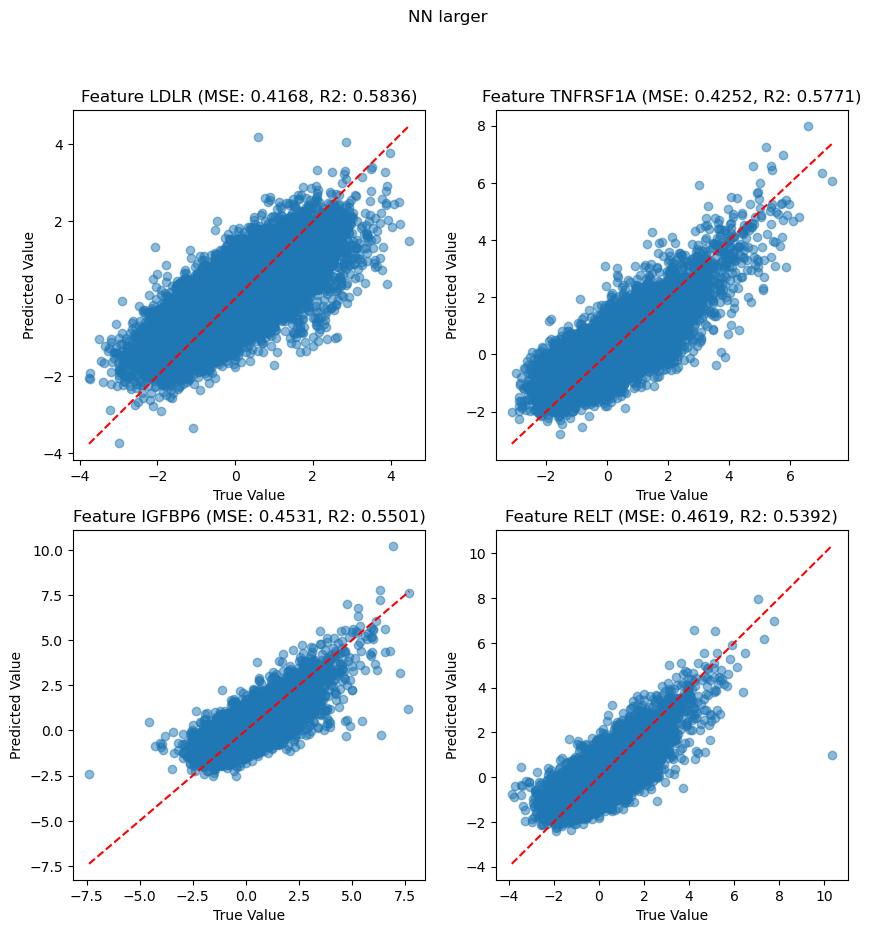

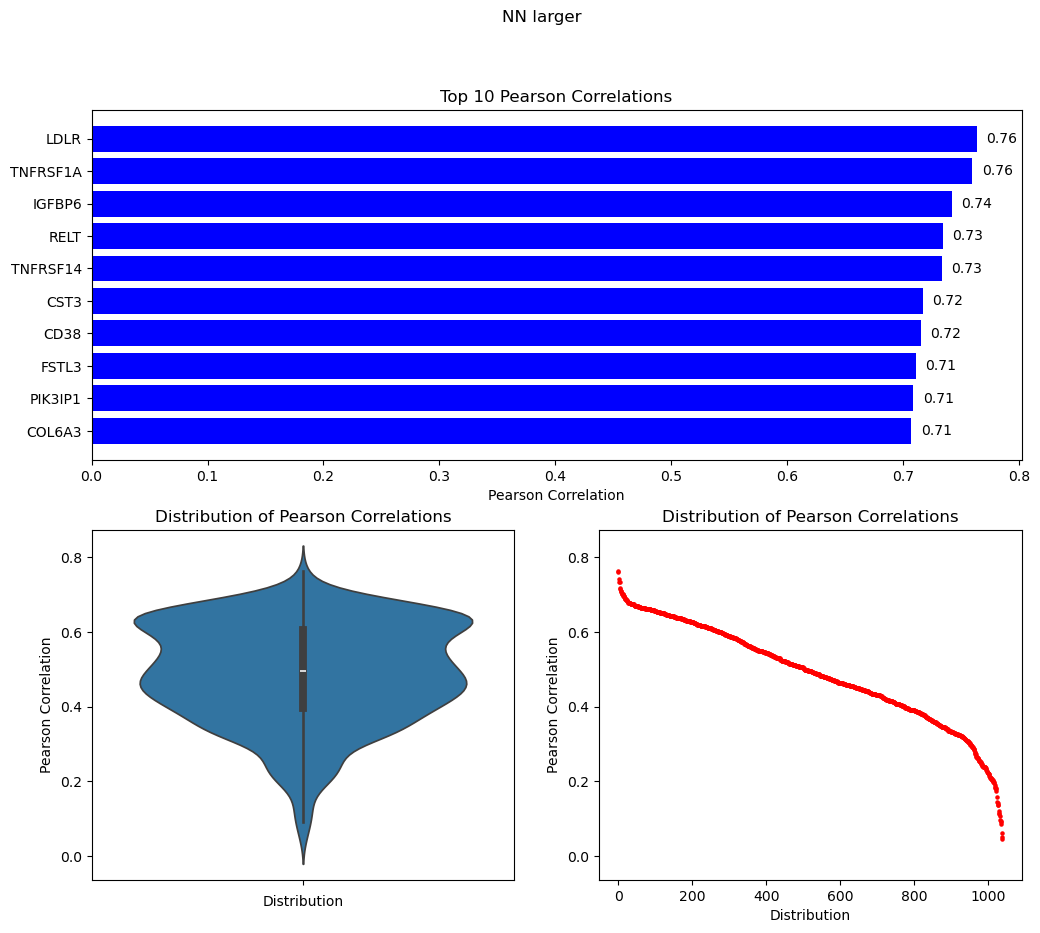

In [5]:
fig,axs = cv.idx_plot(feature_list = np.argsort(mean_squared_error(cv.prot, cv.predict, multioutput='raw_values'))[:4])
fig.suptitle('NN larger')
plt.show(fig)

fig,axs = cv.pred_summary_plot()
fig.suptitle('NN larger')
plt.show(fig)

# finally test it with doing test on the train

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from pytorch_lightning import seed_everything

seed_everything(42)


from utils import *
from sklearn.metrics import mean_squared_error

dataloader = LoadData(impute='KNN',load = True)
cv = CV(dataloader)

Seed set to 42


In [5]:
from sklearn.linear_model import Ridge

reg = Ridge()
reg.fit(cv.met, cv.prot)
pred = reg.predict(cv.met)
print(cv.predict.shape)
cv.predict = pred
print(pred.shape)

(25818, 1039)
(25818, 1039)


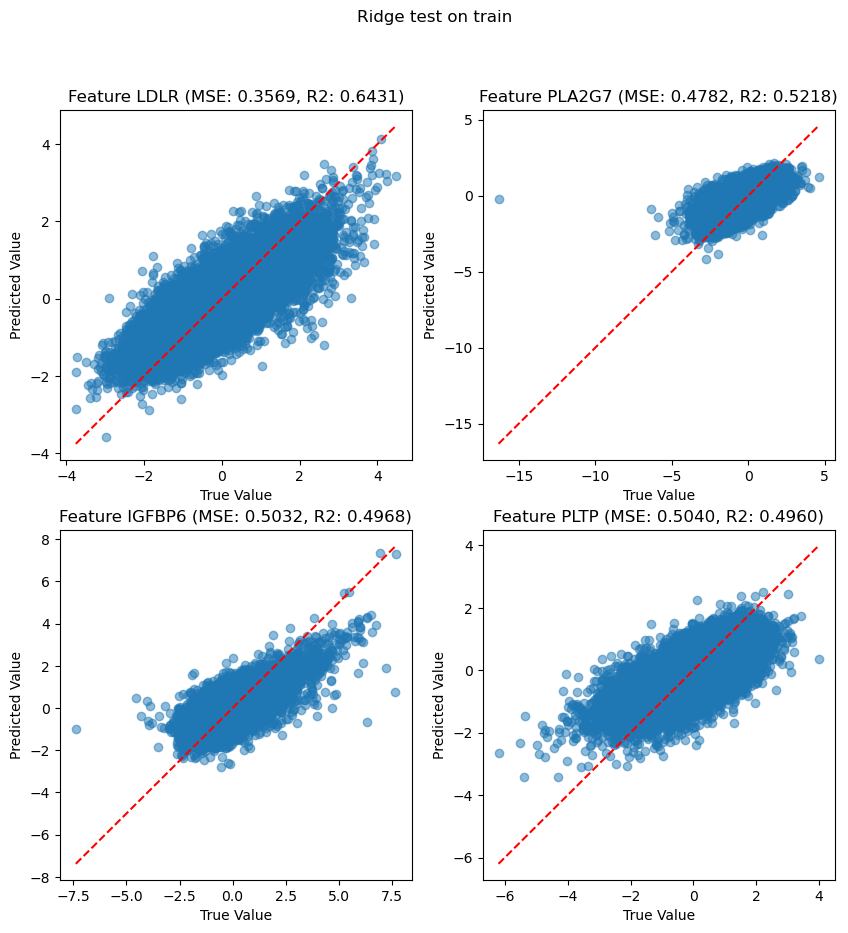

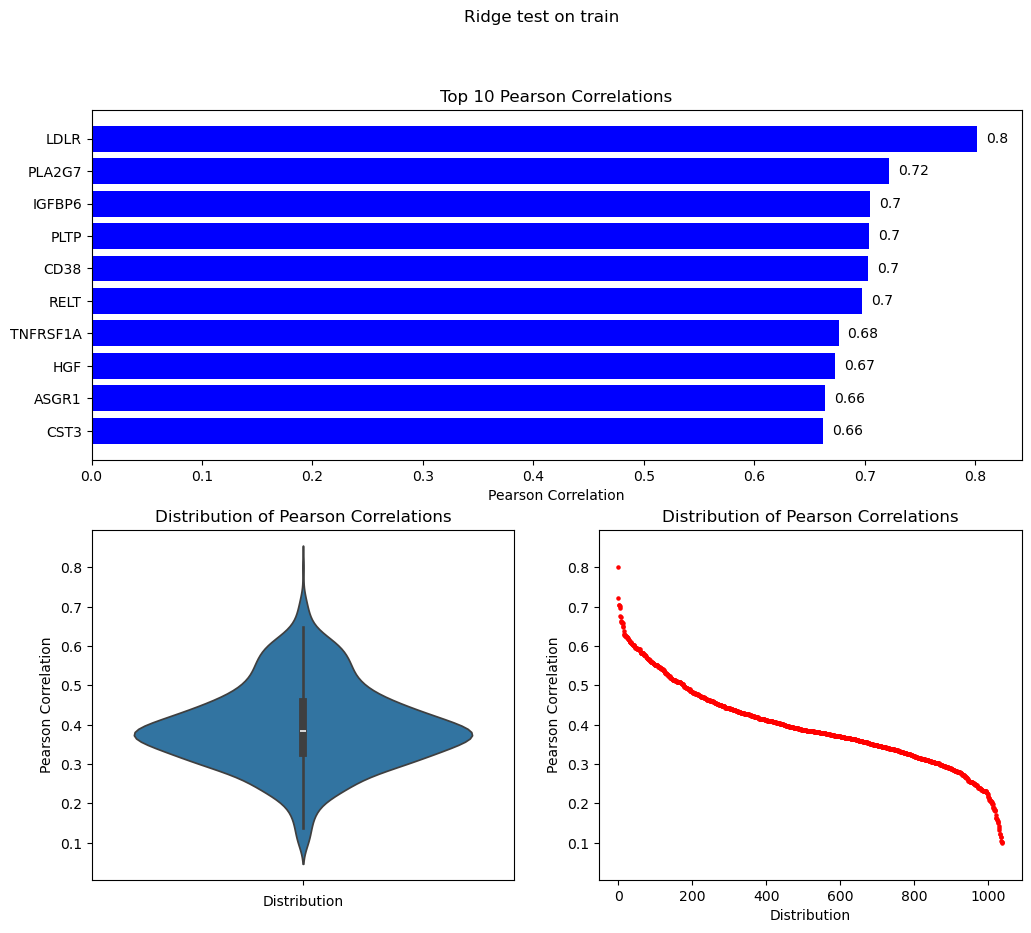

In [6]:
fig,axs = cv.idx_plot(feature_list = np.argsort(mean_squared_error(cv.prot, cv.predict, multioutput='raw_values'))[:4])
fig.suptitle('Ridge test on train')
plt.show(fig)

fig,axs = cv.pred_summary_plot()
fig.suptitle('Ridge test on train')
plt.show(fig)

In [15]:
#now do a simple torch model without pl
custom_layers = nn.Sequential(
    nn.Linear(251, 256),
    nn.ReLU(),
    nn.Linear(256, 512),
    nn.ReLU(),
    nn.Linear(512, 1024),
    nn.ReLU(),
    nn.Linear(1024, 2056),
    nn.ReLU(),
    nn.Linear(2056, 1039)
)
class LinearNet(pl.LightningModule):
    def __init__(self, input_dim=251, output_dim=1039, hidden_dims=[512, 512], custom_layers=None):
        super(LinearNet, self).__init__()
        
        # Use custom layers if provided
        if custom_layers:
            self.layers = custom_layers
        else:
            all_layers = []
            last_dim = input_dim
            for hidden_dim in hidden_dims:
                all_layers.extend([nn.Linear(last_dim, hidden_dim), nn.ReLU()])
                last_dim = hidden_dim
            all_layers.append(nn.Linear(last_dim, output_dim))
            self.layers = nn.Sequential(*all_layers)
        
        self.losses = []

    def forward(self, x):
        x = self.layers(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)
        self.losses.append(loss)
        return {'test_loss': loss}, y_hat

    def on_test_end(self):
        avg_loss = torch.stack([x for x in self.losses]).mean()
        print(f'avg_test_loss: {avg_loss}')
        #self.log('avg_test_loss', avg_loss)
        
    def predict_step(self, batch, batch_idx):
        x, _ = batch
        outputs = self(x)
        return outputs
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LinearNet(custom_layers=custom_layers).to(device)

X = torch.tensor(cv.met, dtype=torch.float32).to(device)
y = torch.tensor(cv.prot, dtype=torch.float32).to(device)
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=128, shuffle=False)
    
trainer = pl.Trainer(max_epochs=50, accelerator='gpu', devices=1, logger=False)

trainer.fit(model, dataloader, dataloader)

pred = trainer.predict(model, dataloader)
pred = torch.cat(pred, dim=0).cpu().numpy()    

print(pred.shape)

/home/sat4017/miniforge3/envs/prot_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/sat4017/miniforge3/envs/prot_torch/lib/python3 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/sat4017/miniforge3/envs/prot_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:630: Checkpoint directory /home/sat4017/PRIME/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 5.0 M 
--------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.864    Total e

/home/sat4017/miniforge3/envs/prot_torch/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=111` in the `DataLoader` to improve performance.
/home/sat4017/miniforge3/envs/prot_torch/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=111` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 202/202 [00:01<00:00, 188.69it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 202/202 [00:01<00:00, 170.63it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]
/home/sat4017/miniforge3/envs/prot_torch/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=111` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 202/202 [00:00<00:00, 678.29it/s]
(25818, 1039)


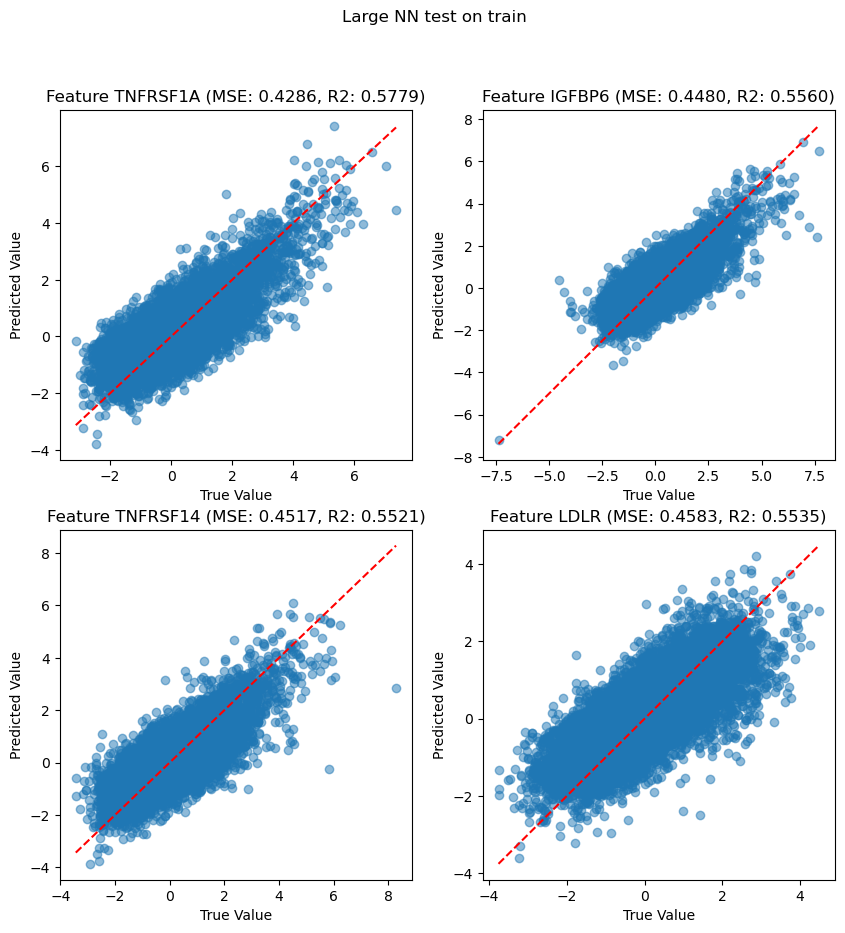

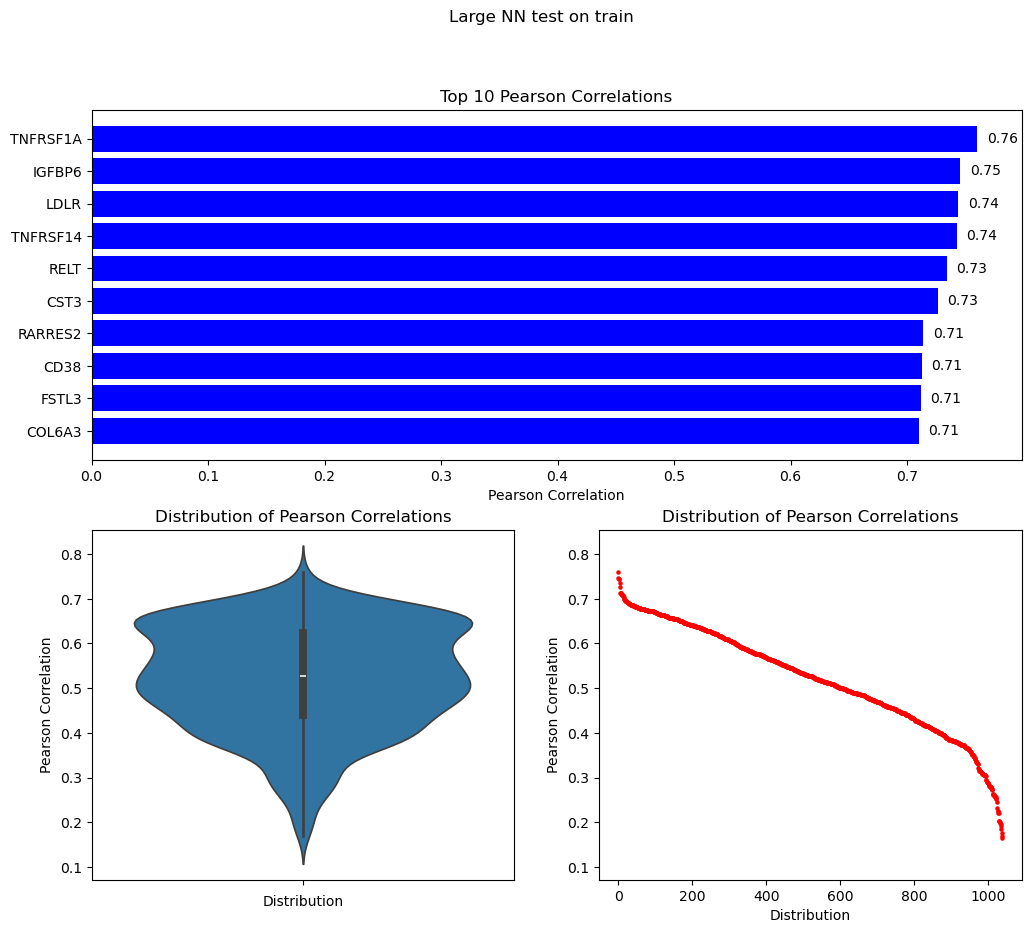

In [17]:
cv.predict = pred

fig,axs = cv.idx_plot(feature_list = np.argsort(mean_squared_error(cv.prot, cv.predict, multioutput='raw_values'))[:4])
fig.suptitle('Large NN test on train')
plt.show(fig)

fig,axs = cv.pred_summary_plot()
fig.suptitle('Large NN test on train')
plt.show(fig)

In [18]:
#and just try the basic pl model training method
cv.train_loop_pl(custom_layers=custom_layers)

Training Folds:   0%|          | 0/5 [00:00<?, ?it/s]/home/sat4017/miniforge3/envs/prot_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/sat4017/miniforge3/envs/prot_torch/lib/python3 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/sat4017/miniforge3/envs/prot_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:630: Checkpoint directory /home/sat4017/PRIME/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name   | Type       | Params
----

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/sat4017/miniforge3/envs/prot_torch/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=111` in the `DataLoader` to improve performance.


/home/sat4017/miniforge3/envs/prot_torch/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=111` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 262.56it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 215.11it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]
/home/sat4017/miniforge3/envs/prot_torch/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=111` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 41/41 [00:00<00:00, 755.59it/s]

Training Folds:  20%|██        | 1/5 [00:08<00:33,  8.27s/it]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 5.0 M 
--------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.864    Total estimated model params size (MB)


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 270.59it/s]                 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 224.66it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting DataLoader 0: 100%|██████████| 41/41 [00:00<00:00, 721.23it/s]

Training Folds:  40%|████      | 2/5 [00:15<00:22,  7.64s/it]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 5.0 M 
--------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.864    Total estimated model params size (MB)


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 274.29it/s]                 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 227.60it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting DataLoader 0: 100%|██████████| 41/41 [00:00<00:00, 758.05it/s]

Training Folds:  60%|██████    | 3/5 [00:22<00:15,  7.52s/it]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 5.0 M 
--------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.864    Total estimated model params size (MB)


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 285.67it/s]                 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 235.52it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting DataLoader 0: 100%|██████████| 41/41 [00:00<00:00, 799.20it/s]

Training Folds:  80%|████████  | 4/5 [00:30<00:07,  7.40s/it]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 5.0 M 
--------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.864    Total estimated model params size (MB)


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 282.05it/s]                 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 233.52it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting DataLoader 0: 100%|██████████| 41/41 [00:00<00:00, 796.09it/s]

Training Folds: 100%|██████████| 5/5 [00:37<00:00,  7.45s/it]

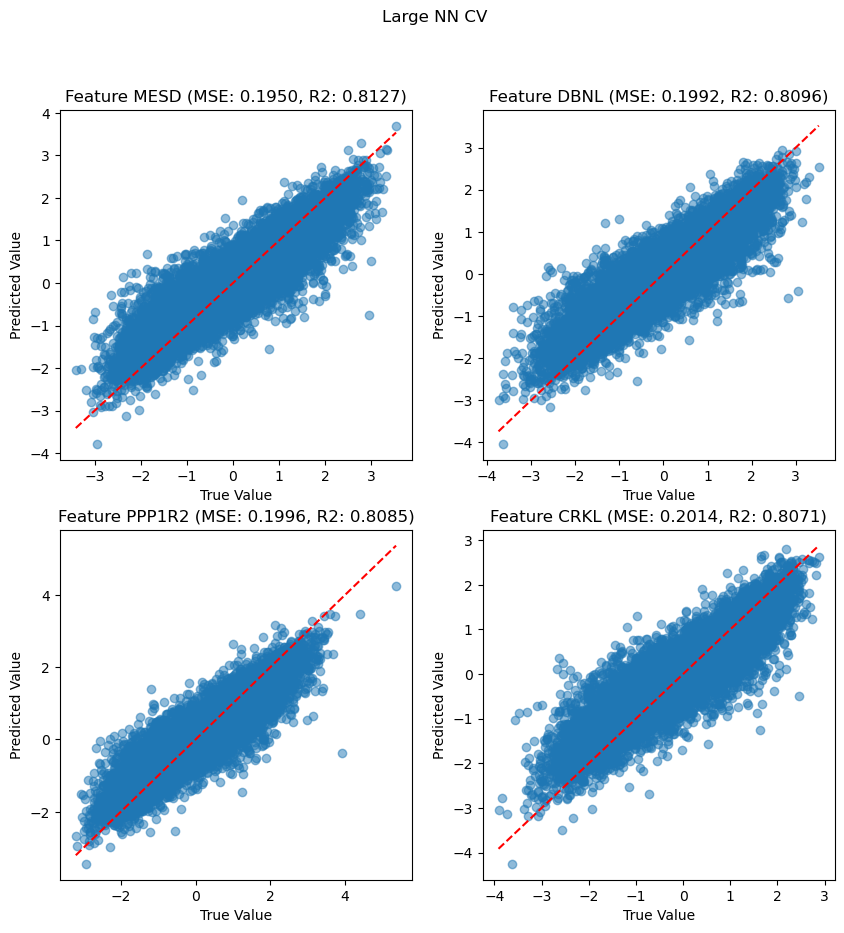

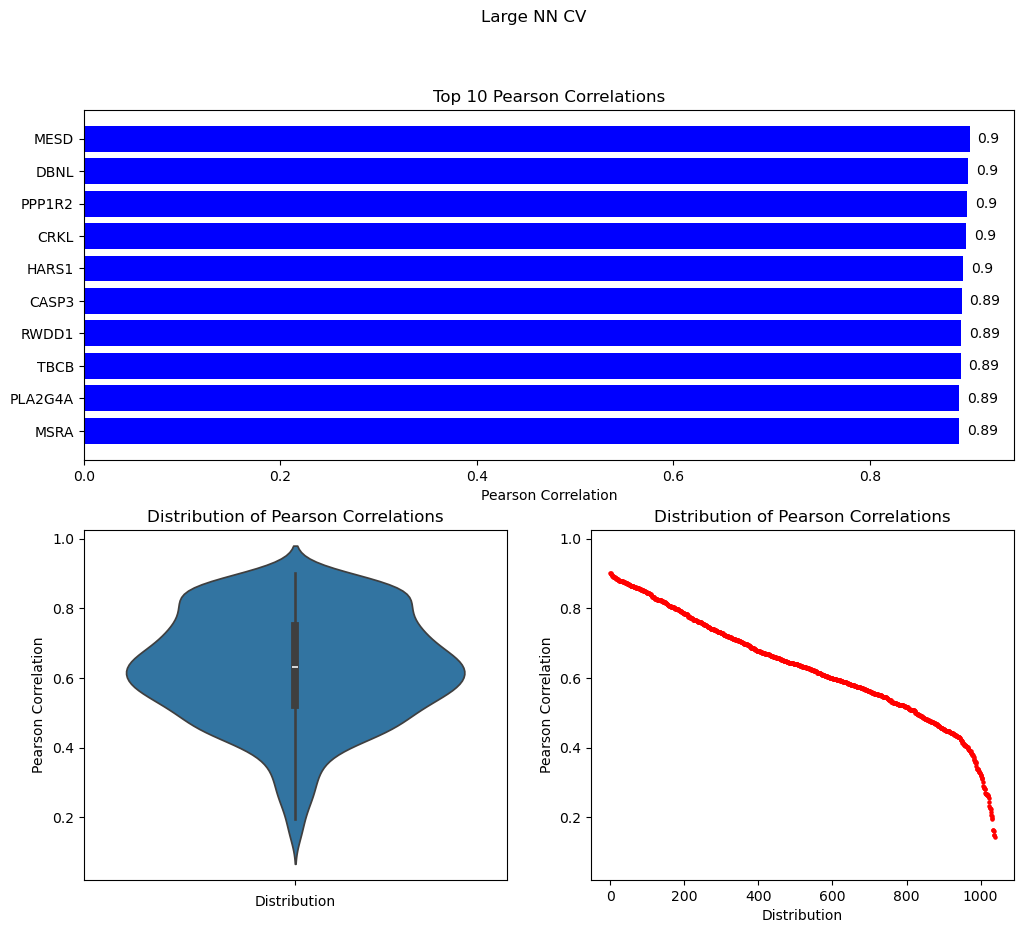

In [19]:
fig,axs = cv.idx_plot(feature_list = np.argsort(mean_squared_error(cv.prot, cv.predict, multioutput='raw_values'))[:4])
fig.suptitle('Large NN CV')
plt.show(fig)

fig,axs = cv.pred_summary_plot()
fig.suptitle('Large NN CV')
plt.show(fig)

Training Folds:   0%|          | 0/5 [00:00<?, ?it/s]/home/sat4017/miniforge3/envs/prot_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/sat4017/miniforge3/envs/prot_torch/lib/python3 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/sat4017/miniforge3/envs/prot_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:630: Checkpoint directory /home/sat4017/PRIME/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name   | Type       | Params
----

/home/sat4017/miniforge3/envs/prot_torch/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=111` in the `DataLoader` to improve performance.
/home/sat4017/miniforge3/envs/prot_torch/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=111` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 287.01it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 232.20it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]
/home/sat4017/miniforge3/envs/prot_torch/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=111` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 41/41 [00:00<00:00, 805.71it/s]

Training Folds:  20%|██        | 1/5 [00:07<00:29,  7.35s/it]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 5.0 M 
--------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.864    Total estimated model params size (MB)


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 289.20it/s]                 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 239.78it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting DataLoader 0: 100%|██████████| 41/41 [00:00<00:00, 798.79it/s]


Training Folds:  40%|████      | 2/5 [00:14<00:21,  7.18s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 5.0 M 
--------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.864    Total estimated model params size (MB)


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 285.24it/s]                 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 234.52it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting DataLoader 0: 100%|██████████| 41/41 [00:00<00:00, 778.80it/s]

Training Folds:  60%|██████    | 3/5 [00:24<00:16,  8.48s/it]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 5.0 M 
--------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.864    Total estimated model params size (MB)


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 281.56it/s]                 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 230.18it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting DataLoader 0: 100%|██████████| 41/41 [00:00<00:00, 781.71it/s]

Training Folds:  80%|████████  | 4/5 [00:31<00:07,  7.99s/it]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 5.0 M 
--------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.864    Total estimated model params size (MB)


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 284.66it/s]                 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 231.48it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting DataLoader 0: 100%|██████████| 41/41 [00:00<00:00, 788.66it/s]

Training Folds: 100%|██████████| 5/5 [00:39<00:00,  7.81s/it]


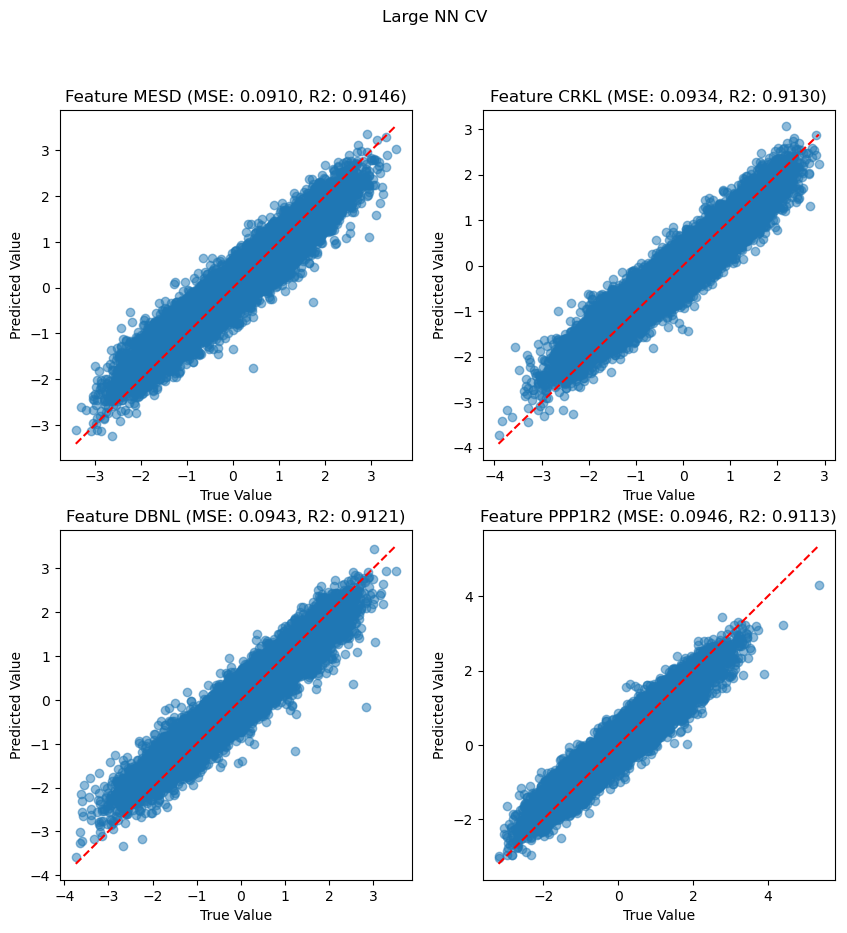

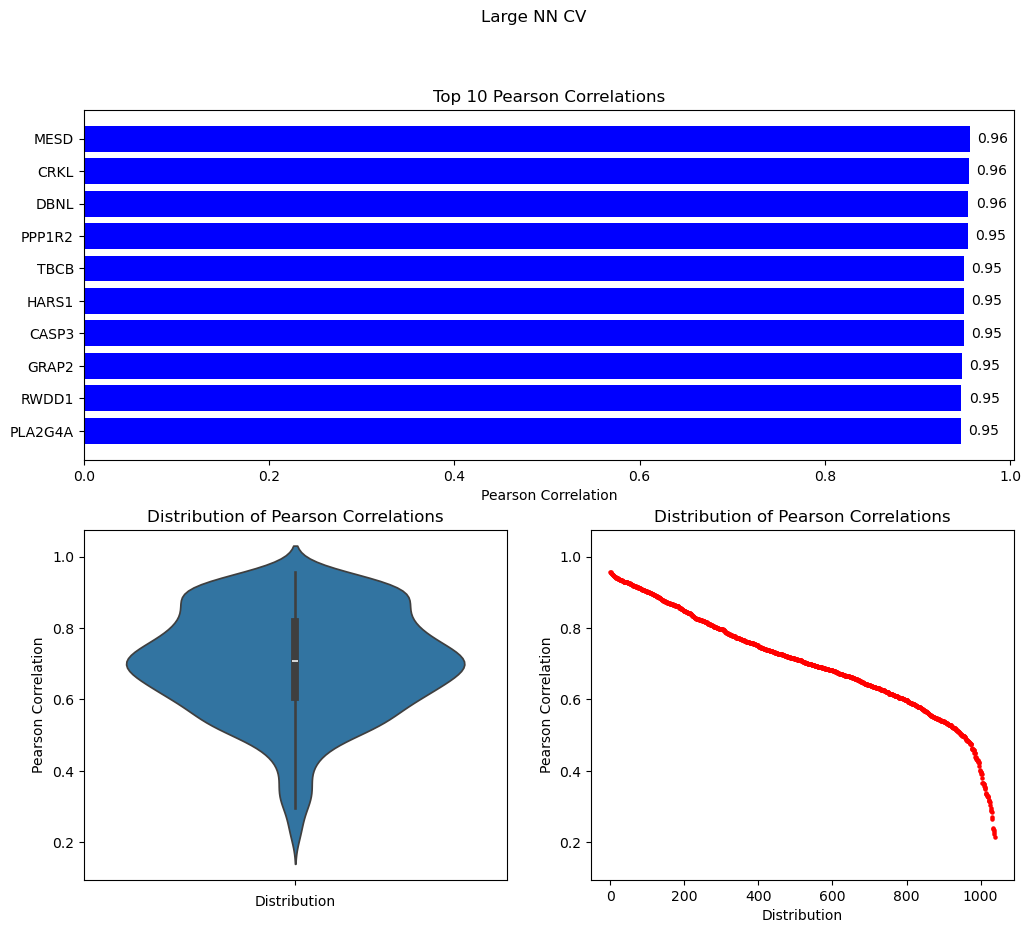

In [20]:
#lmao i'm going to assume this si abug, this makes no sense that CV is that much better with a large model, definitely a sort of bug lmfao!
#and just try the basic pl model training method
cv.predict = np.zeros(cv.predict.shape) #clearly not the issue
cv.train_loop_pl(custom_layers=custom_layers)
fig,axs = cv.idx_plot(feature_list = np.argsort(mean_squared_error(cv.prot, cv.predict, multioutput='raw_values'))[:4])
fig.suptitle('Large NN CV')
plt.show(fig)

fig,axs = cv.pred_summary_plot()
fig.suptitle('Large NN CV')
plt.show(fig)

In [ ]:
#first manually compare predictions to cv.prot



# potential fix using deepcopy

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning import seed_everything

seed_everything(42)


from utils import *
from sklearn.metrics import mean_squared_error

dataloader = LoadData(impute='KNN',load = True)
cv = CV(dataloader)

Seed set to 42


In [22]:
custom_layers = nn.Sequential(
    nn.Linear(251, 256),
    nn.ReLU(),
    nn.Linear(256, 512),
    nn.ReLU(),
    nn.Linear(512, 1024),
    nn.ReLU(),
    nn.Linear(1024, 2056),
    nn.ReLU(),
    nn.Linear(2056, 1039)
)

cv.train_loop_pl(custom_layers=custom_layers)

Training Folds:   0%|          | 0/5 [00:00<?, ?it/s]/home/sat4017/miniforge3/envs/prot_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/sat4017/miniforge3/envs/prot_torch/lib/python3 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/sat4017/miniforge3/envs/prot_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:630: Checkpoint directory /home/sat4017/PRIME/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name   | Type       | Params
----

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/sat4017/miniforge3/envs/prot_torch/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=111` in the `DataLoader` to improve performance.


/home/sat4017/miniforge3/envs/prot_torch/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=111` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 283.59it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 239.21it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]
/home/sat4017/miniforge3/envs/prot_torch/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=111` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 41/41 [00:00<00:00, 777.22it/s]


Training Folds:  20%|██        | 1/5 [00:07<00:30,  7.60s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 5.0 M 
--------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.864    Total estimated model params size (MB)


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 283.51it/s]                 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 236.81it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting DataLoader 0: 100%|██████████| 41/41 [00:00<00:00, 702.04it/s]


Training Folds:  40%|████      | 2/5 [00:14<00:22,  7.35s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 5.0 M 
--------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.864    Total estimated model params size (MB)


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 253.46it/s]                 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 215.27it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting DataLoader 0: 100%|██████████| 41/41 [00:00<00:00, 796.09it/s]


Training Folds:  60%|██████    | 3/5 [00:21<00:14,  7.27s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 5.0 M 
--------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.864    Total estimated model params size (MB)


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 270.79it/s]                 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 224.41it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting DataLoader 0: 100%|██████████| 41/41 [00:00<00:00, 787.94it/s]

Training Folds:  80%|████████  | 4/5 [00:29<00:07,  7.27s/it]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 5.0 M 
--------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.864    Total estimated model params size (MB)


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 286.66it/s]                 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 232.72it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting DataLoader 0: 100%|██████████| 41/41 [00:00<00:00, 790.22it/s]

Training Folds: 100%|██████████| 5/5 [00:36<00:00,  7.30s/it]

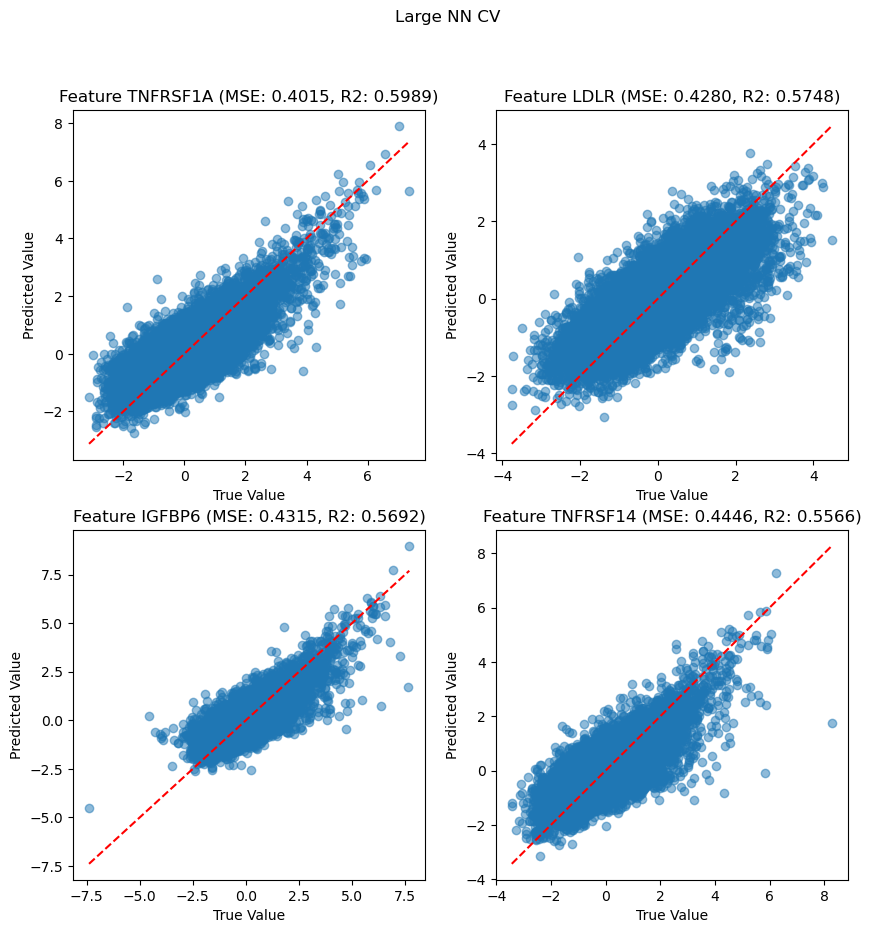

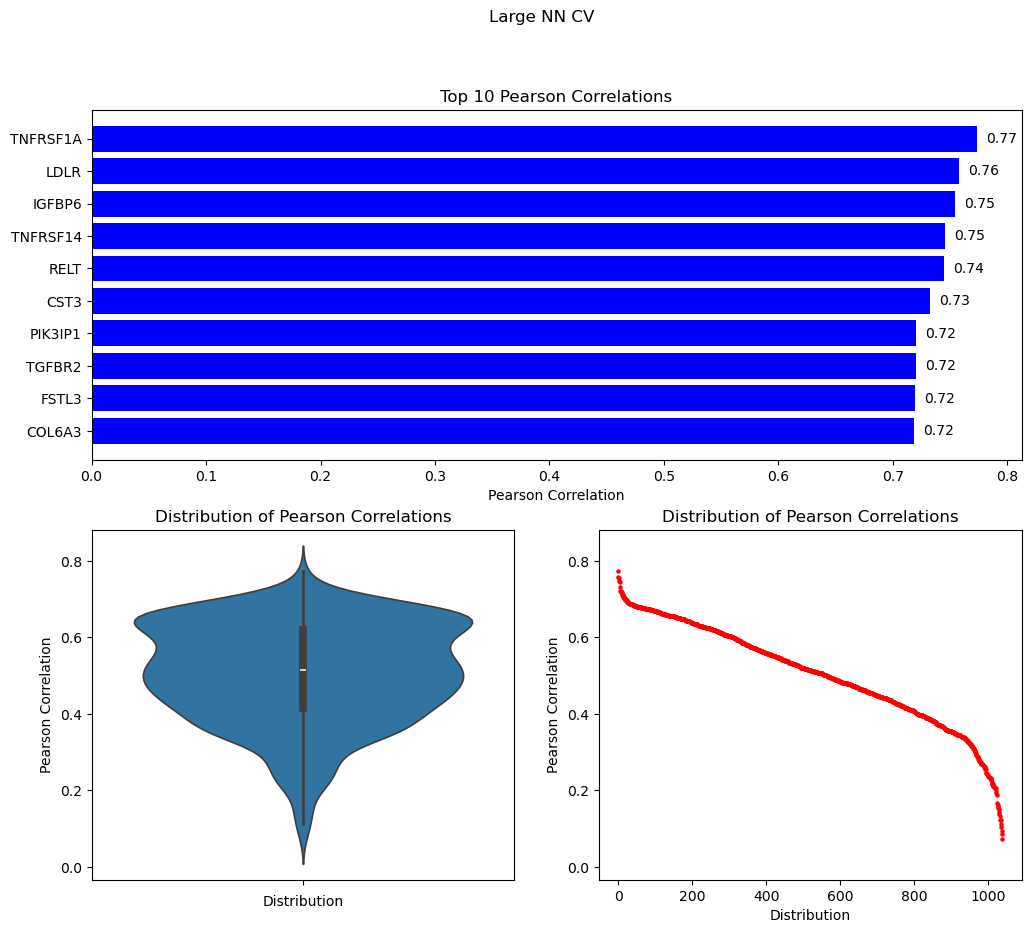

In [23]:
#now plot results

fig,axs = cv.idx_plot(feature_list = np.argsort(mean_squared_error(cv.prot, cv.predict, multioutput='raw_values'))[:4])
fig.suptitle('Large NN CV')
plt.show(fig)

fig,axs = cv.pred_summary_plot()
fig.suptitle('Large NN CV')
plt.show(fig)

# now we test to see why the CV no reset model is better than the trian and test on full dataset